In [27]:
import bz2
import math
import os
import shutil
import zipfile

import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import supervisely as sly
from icrawler.builtin import GoogleImageCrawler
from kaggle.api.kaggle_api_extended import KaggleApi
from PIL import Image, ImageOps

In [28]:
current_dir = os.getcwd()
print("Текущая рабочая директория:", current_dir)

Текущая рабочая директория: /Users/kaledinaoa/Desktop/OneCell


# 1. Базовая работа с python/numpy

1. Скачайте 10-20 изображений с лицами из интернета какими удобно средствами (например)

2. Воспользуйтесь одним из готовых face-detector/face-landmark-detector для того, чтобы на выбранных изображениях найти лицо и ключевые точки на лице. Можно для этого взять связку библиотек OpenCV (opencv-python) & dlib (dlib-python). 

3. Результат детектирования лица (bbox) & landmarks (points) визуализировать в jupyter-notebook для первых 5-10 картинок. 
Для визуализации можно использовать matplotlib, например 🕷️


### Скачиваем изображения из Google

Испльзуем GoogleImageCrawler для загрузки

Переменная num_img_down используется для определения количества загружаемых изображений

In [3]:
# Папка для сохранения изображений
output_dir = 'data/trump_images'

num_img_down = 10

# Функция для удаления папки, если она существует
def remove_folder_if_exists(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder {folder_path} removed.")

remove_folder_if_exists(output_dir)

# Создание экземпляра GoogleImageCrawler и загрузка изображений
google_crawler = GoogleImageCrawler(storage={'root_dir': output_dir})
google_crawler.crawl(keyword='Donald Trump', max_num=num_img_down, min_size=(400, 400), max_size=None)

2024-06-25 20:57:13,304 - INFO - icrawler.crawler - start crawling...
2024-06-25 20:57:13,304 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-06-25 20:57:13,305 - INFO - feeder - thread feeder-001 exit
2024-06-25 20:57:13,305 - INFO - icrawler.crawler - starting 1 parser threads...
2024-06-25 20:57:13,306 - INFO - icrawler.crawler - starting 1 downloader threads...


Folder data/trump_images removed.


2024-06-25 20:57:13,927 - INFO - parser - parsing result page https://www.google.com/search?q=Donald+Trump&ijn=0&start=0&tbs=&tbm=isch
2024-06-25 20:57:14,995 - INFO - downloader - image #1	https://upload.wikimedia.org/wikipedia/commons/5/56/Donald_Trump_official_portrait.jpg
2024-06-25 20:57:15,342 - INFO - downloader - image #2	https://hips.hearstapps.com/hmg-prod/images/former-u-s-president-donald-trump-speaks-to-reporters-news-photo-1680289458.jpg
2024-06-25 20:57:15,507 - INFO - downloader - image #3	https://cdn.britannica.com/31/149831-050-83A0E45B/Donald-J-Trump-2010.jpg
2024-06-25 20:57:16,754 - INFO - downloader - image #4	https://i.natgeofe.com/k/5e4ea67e-2219-4de4-9240-2992faef0cb6/trump-portrait_2x3.jpg
2024-06-25 20:57:16,999 - ERROR - downloader - Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Donald_Trump_August_19%2C_2015_%28cropped%29.jpg
2024-06-25 20:57:17,304 - INFO - downloader - image #5	https://assets.editorial.aetnd.com/

Изменяем разрешение изображений чтобы привести их к одинаковому это поможет в изображении детектированных точек

In [4]:
def resize_image(image_path, target_size=400):
    with Image.open(image_path) as img:
        if img.height > img.width:
            # Вертикальное изображение
            new_height = target_size
            aspect_ratio = img.width / img.height
            new_width = int(target_size * aspect_ratio)
        else:
            # Горизонтальное изображение
            new_width = target_size
            aspect_ratio = img.height / img.width
            new_height = int(target_size * aspect_ratio)
        
        # Изменяем размер изображения с сохранением пропорций
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        img.save(image_path)

# Изменение размера всех загруженных изображений
for filename in os.listdir(output_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(output_dir, filename)
        resize_image(image_path)

Переходим к модели по детектированию точек. Перед началом работы необходимо ее скачать в папку models

In [5]:
folder_path = "models"
file_model = "shape_predictor_68_face_landmarks.dat"

# Проверка существования папки models/
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Создана директория models/")

%cd models

# Проверка существования файла модели
if not os.path.exists(file_model):
    print(f"Скачиваем модель {file_model}")
    url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    compressed_file_path = "shape_predictor_68_face_landmarks.dat.bz2"
    decompressed_file_path = file_model
    response = requests.get(url, stream=True)
    with open(compressed_file_path, "wb") as f:
        f.write(response.content)

    with bz2.open(compressed_file_path, "rb") as f_in, open(decompressed_file_path, "wb") as f_out:
        f_out.write(f_in.read())

    os.remove(compressed_file_path)
    print("Файл успешно скачан и распакован:", decompressed_file_path)
else:
    print(f"Модель {file_model} уже существует в папке models/")

%cd ..

/Users/kaledinaoa/Desktop/OneCell/models
Модель shape_predictor_68_face_landmarks.dat уже существует в папке models/
/Users/kaledinaoa/Desktop/OneCell


Создаем детектор и предиктор

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

Создаем функцию отрисовки 

In [7]:
def print_image(image, detector, image_file, i):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        x1 = face.left() 
        y1 = face.top()  
        x2 = face.right()
        y2 = face.bottom()
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)

        landmarks = predictor(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 1, (0, 255, 255), -1) 

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Image {i}: {image_file}")
    plt.show()

Выбираем первые 5 изображений (можно больше/меньше в зависимости от переменной num_img_print)

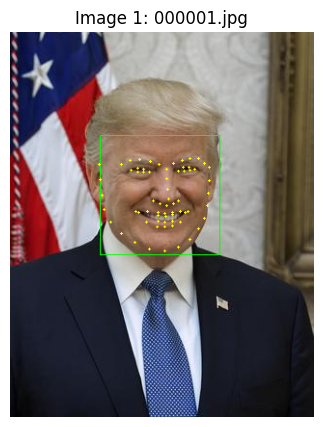

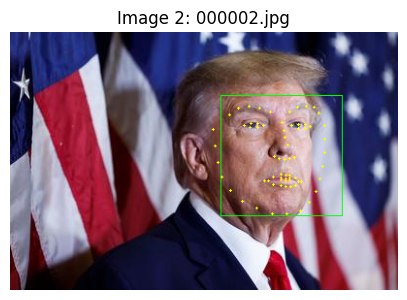

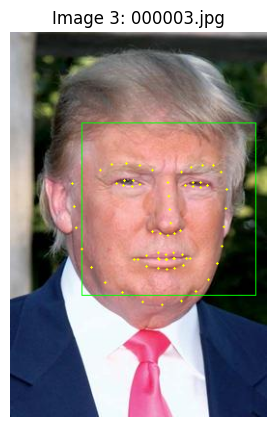

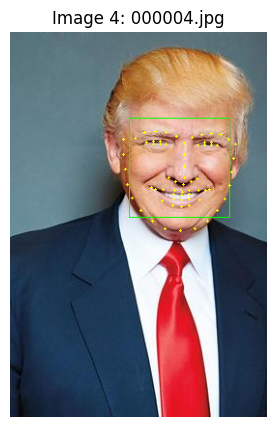

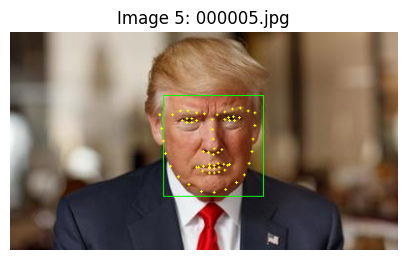

In [8]:
num_img_print = 5

image_dir = output_dir
image_files = sorted(os.listdir(image_dir))

for i, image_file in enumerate(image_files[:min(num_img_print,num_img_down)], start=1):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Skipping {image_file}. Image not loaded.")
        continue

    print_image(image, detector, image_file, i)


# 2. Оценка метрик и валидация моделей

1. Скачайте датасет с kaggle-соревнования Kaggle: Facial Keypoints Detection

2. Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета

3. Посчитайте метрики для Ground-Truth точек которые эквивалентны точкам из модели (в opencv 68-point модель, в kaggle разметка для 15-точек).

4. Подумайте, предложите метрики, которые стоит посчитать для этой задачи. Мы хотим при помощи этих метрик оценить несколько факторов:
    - оценить точность детектирования каждой из точек и всех точек в среднем
    - оценить точность позиционирования (насколько точки смещаются относительно GT) для каждой landmark и в среднем

5. Отберите и визуализируйте (изображение + точки Ground Truth + Predicts) 3-5 изображений с самым высоким качеством детектирования и с самым низким.

### Импорт данных

#### Импорт данных из kaggle

%kaggle datasets download -d kaggle/facial-keypoints-detection -p data/kaggle/

1. Скачать ваш собственный токен с сайта kaggle

2. Cоздать папку .kaggle 

mkdir -p ~/.kaggle

3. перенести его из загрузок в папку .kaggle

mv ~/Downloads/kaggle.json ~/.kaggle/kaggle.json

In [9]:
# айтентификация и скачивание архива соревнования
api = KaggleApi()
api.authenticate()

dataset_name = 'facial-keypoints-detection'
output_dir = f'data/kaggle/{dataset_name}/'

api.competition_download_files(dataset_name, path=output_dir)

In [10]:
# Разархимируем и разложим все удобно
name_subfolder = "input/"
current_dir = "data/kaggle/facial-keypoints-detection/"

target_subfolder=f"{current_dir}{name_subfolder}"

zip_path = os.path.join(current_dir, f'{dataset_name}.zip')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(current_dir)

os.remove(zip_path)

if not os.path.exists(target_subfolder):
    os.makedirs(target_subfolder)

files = [file for file in os.listdir(current_dir) if os.path.isfile(os.path.join(current_dir, file))]

for file in files:
    file_path = os.path.join(current_dir, file)
    target_file_path = os.path.join(target_subfolder, file)
    shutil.move(file_path, target_file_path)

with zipfile.ZipFile(f"{target_subfolder}training.zip", "r") as zip_ref:
    zip_ref.extractall(f"{current_dir}working/")

with zipfile.ZipFile(f"{target_subfolder}test.zip", "r") as zip_ref:
    zip_ref.extractall(f"{current_dir}working/")

### перейдем к данным

In [11]:
train_df = pd.read_csv(f"{current_dir}working/training.csv")
test_df = pd.read_csv(f"{current_dir}working/test.csv")

In [12]:
# Используем прошлую модель
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

def str_to_image(str_img):
    return np.array(str_img.split(), dtype=np.uint8).reshape(96, 96)

train_df['Image'] = train_df['Image'].apply(str_to_image)
test_df['Image'] = test_df['Image'].apply(str_to_image)

In [13]:
# Cоздаем словарь детектированных точек
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        face = faces[0]
        landmarks = predictor(gray, face)
        model_68_points_dict = {
            'left_eye_center': ((landmarks.part(42).x + landmarks.part(45).x) // 2, (landmarks.part(42).y + landmarks.part(45).y) // 2),
            'right_eye_center': ((landmarks.part(36).x + landmarks.part(39).x) // 2, (landmarks.part(36).y + landmarks.part(39).y) // 2),
            'left_eye_inner_corner': (landmarks.part(42).x, landmarks.part(42).y),
            'left_eye_outer_corner': (landmarks.part(45).x, landmarks.part(45).y),
            'right_eye_inner_corner': (landmarks.part(39).x, landmarks.part(39).y),
            'right_eye_outer_corner': (landmarks.part(36).x, landmarks.part(36).y),
            'left_eyebrow_inner_end': (landmarks.part(22).x, landmarks.part(22).y),
            'left_eyebrow_outer_end': (landmarks.part(26).x, landmarks.part(26).y),
            'right_eyebrow_inner_end': (landmarks.part(21).x, landmarks.part(21).y),
            'right_eyebrow_outer_end': (landmarks.part(17).x, landmarks.part(17).y),
            'nose_tip': (landmarks.part(30).x, landmarks.part(30).y),
            'mouth_left_corner': (landmarks.part(54).x, landmarks.part(54).y),
            'mouth_right_corner': (landmarks.part(48).x, landmarks.part(48).y),
            'mouth_center_top_lip': (landmarks.part(51).x, landmarks.part(51).y),
            'mouth_center_bottom_lip': (float(landmarks.part(57).x), float(landmarks.part(57).y))
        }
        return model_68_points_dict
    return []


# Cоздаем словарь тестовых точек
def get_ground_truth_points(row):
    true_points_dict = {}
    for column in train_df.columns:
        if column.endswith('_x'):
            key = column[:-2] 
            x_value = row[column]
            y_column = column[:-2] + '_y'
            y_value = row[y_column]
            true_points_dict[key] = (x_value, y_value)
    return true_points_dict

### Исследование метрик

In [14]:
import numpy as np

def euclidean_distance(true_x, true_y, detected_x, detected_y):
    return np.sqrt((true_x - detected_x)**2 + (true_y - detected_y)**2)

def mse(true_x, true_y, detected_x, detected_y):
    return np.mean((true_x - detected_x)**2 + (true_y - detected_y)**2)

def mae(true_x, true_y, detected_x, detected_y):
    return np.mean(np.abs(true_x - detected_x) + np.abs(true_y - detected_y))

def r_squared(true_x, true_y, detected_x, detected_y):
    # Compute the mean of true coordinates
    mean_true_x = np.mean(true_x)
    mean_true_y = np.mean(true_y)
    
    # Compute the total sum of squares (SS_tot)
    ss_tot = np.sum((true_x - mean_true_x)**2) + np.sum((true_y - mean_true_y)**2)
    
    # Compute the sum of squared residuals (SS_res)
    ss_res = np.sum((true_x - detected_x)**2) + np.sum((true_y - detected_y)**2)
    
    # Compute R-squared
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    return r_squared

def rmse(true_x, true_y, detected_x, detected_y):
    return np.sqrt(np.mean((true_x - detected_x)**2 + (true_y - detected_y)**2))

def pck(true_x, true_y, detected_x, detected_y, threshold):
    """Процент точек с ошибкой меньше заданного порога (Percentage of Correct Keypoints, PCK)."""
    distances = euclidean_distance(true_x, true_y, detected_x, detected_y)
    correct_points = np.mean(distances < threshold)
    pck_value = correct_points * 100
    return pck_value

def compute_metrics(true_x, true_y, detected_x, detected_y):
    """Вычисляет различные метрики по заданным координатам точек."""
    metrics = {}
    metrics['euclidean_distance'] = euclidean_distance(true_x, true_y, detected_x, detected_y)
    metrics['mse'] = mse(true_x, true_y, detected_x, detected_y)
    metrics['mae'] = mae(true_x, true_y, detected_x, detected_y)
    metrics['r_squared'] = r_squared(true_x, true_y, detected_x, detected_y)
    metrics['rmse'] = rmse(true_x, true_y, detected_x, detected_y)
    metrics['pck01'] = pck(true_x, true_y, detected_x, detected_y, threshold=0.1)  
    metrics['pck03'] = pck(true_x, true_y, detected_x, detected_y, threshold=0.3) 
    metrics['pck05'] = pck(true_x, true_y, detected_x, detected_y, threshold=0.5) 
    metrics['pck1'] = pck(true_x, true_y, detected_x, detected_y, threshold=1.0)
    return metrics

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def area_under_ced(distances, print = False):
    # Сортировка расстояний в порядке возрастания
    sorted_distances = np.sort(distances)
    max_threshold = np.max(distances)
    # Количество точек
    num_points = len(sorted_distances)
    
    # Пороги для CED (для каждой точки в sorted_distances)
    thresholds = sorted_distances
    
    # Пустые списки для хранения значений
    threshold_values = []
    correct_percentage = []
    
    # Вычисление процентов точек с ошибкой меньше порога
    for i, threshold in enumerate(thresholds):
        correct_points = np.mean(sorted_distances < threshold) * 100.0
        threshold_values.append(threshold)
        correct_percentage.append(correct_points)
    
    if print==True:
        # Построение кривой CED
        plt.figure(figsize=(5, 5))
        plt.plot(threshold_values, correct_percentage, marker='o', linestyle='-')
        plt.xlabel('Threshold')
        plt.ylabel('Percentage of correct points')
        plt.title('Cumulative Error Distribution (CED) Curve')
        plt.grid(True)
        plt.show()
    
    # Вычисление площади под кривой CED (AUC CED) методом трапеций
    auc_ced = np.trapz(correct_percentage, threshold_values) / 100.0  # Делим на 100, чтобы перевести в доли
    
    # Вычисление общей площади графика CED (площадь треугольника)
    total_area = 0.5 * max_threshold * 100  # 0.5 * основание * высота
    
    # Нормирование площади под кривой на общую площадь графика CED
    normalized_auc_ced = auc_ced / total_area
    return auc_ced

# Пример использования функции для вычисления AUC CED
distances = np.array([0.5, 0.8, 1.2, 0.3, 0.9])  # Пример массива расстояний
print(f"Area Under the CED Curve (AUC CED): {area_under_ced(distances)}")


Area Under the CED Curve (AUC CED): 0.37


In [17]:
import numpy as np
import pandas as pd
import cv2

# Предположим, что у вас есть все необходимые функции для работы с изображениями, метриками и т.д.

def process_images(train_df):
    prediction = {}
    my_metric = pd.DataFrame()  # Создаем пустой DataFrame для метрик

    for i in range(1, train_df['Image'].count()):
        sample_image = cv2.cvtColor(train_df.iloc[i]['Image'], cv2.COLOR_BGR2RGB)

        true_points_dict = get_ground_truth_points(train_df.iloc[i])
        detected_points_dict = detect_landmarks(sample_image)

        difference_dict = {}

        for key, (true_x, true_y) in true_points_dict.items():
            if key in detected_points_dict:
                detected_x, detected_y = detected_points_dict[key]

                if not np.isnan(true_x) and not np.isnan(detected_x) and not np.isnan(true_y) and not np.isnan(detected_y):
                    # Вычисляем метрики
                    metrics = compute_metrics(true_x, true_y, detected_x, detected_y)
                    
                    # Сохраняем результаты в difference_dict
                    difference_dict[key] = [true_x, detected_x, true_y, detected_y, (true_x - detected_x, true_y - detected_y)]
                    for metric_name, metric_value in metrics.items():
                        difference_dict[key].append(metric_value)
        
        if difference_dict:
            columns = ['true_x', 'detected_x', 'true_y', 'detected_y', 'diff_xy'] + list(metrics.keys())
            pred_df = pd.DataFrame.from_dict(difference_dict, orient='index', columns=columns)
            prediction[i] = pred_df
            
            # Вычисляем средние значения для каждой метрики и добавляем в my_metric
            metrics_mean = {}
            for metric in metrics.keys():
                valid_values = pred_df[metric].dropna()
                metrics_mean[metric] = np.nanmean(valid_values) if not valid_values.empty else np.nan
            
            metrics_mean['auc'] = area_under_ced(prediction[i].euclidean_distance)
            metrics_mean_series = pd.Series(metrics_mean, name=i)  # Создаем Series с именем i
            my_metric = pd.concat([my_metric, metrics_mean_series.to_frame().T])  # Добавляем Series в DataFrame

    my_metric.index.name = 'image_id'  # Устанавливаем имя индекса

    return prediction, my_metric


# Пример использования функции
prediction, my_metric = process_images(train_df)


In [18]:
my_metric.head()

,euclidean_distance,mse,mae,r_squared,rmse,pck01,pck03,pck05,pck1,auc
image_id,,,,,,,,,,
1,1.656574,3.494183,2.053438,0.0,1.656574,0.000000,0.000000,6.666667,13.333333,1.665949
2,1.173605,1.779025,1.483971,0.0,1.173605,0.000000,0.000000,20.000000,40.000000,1.540525
3,1.415221,2.827374,1.725793,0.0,1.415221,0.000000,0.000000,13.333333,40.000000,2.100097
4,2.518206,8.821228,3.058847,0.0,2.518206,6.666667,6.666667,6.666667,13.333333,3.738776
5,1.916221,4.930674,2.474756,0.0,1.916221,0.000000,0.000000,0.000000,26.666667,2.359961


In [19]:
# Визуализация детектированных точек
def visualize_prediction(image, pred_df):
    for index, row in pred_df.iterrows():
        true_x = row["true_x"]
        true_y = row["true_y"]
        detected_x = row["detected_x"]
        detected_y = row["detected_y"]

        # Проверяем, что значения не NaN 
        if not np.isnan(true_x) and not np.isnan(true_y):
            cv2.circle(image, (int(true_x), int(true_y)), 1, (0, 255, 0), -1) # зеленые

        if not np.isnan(detected_x) and not np.isnan(detected_y):
            cv2.circle(image, (int(detected_x), int(detected_y)), 1, (0, 0, 255), -1)   # красные
        
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    

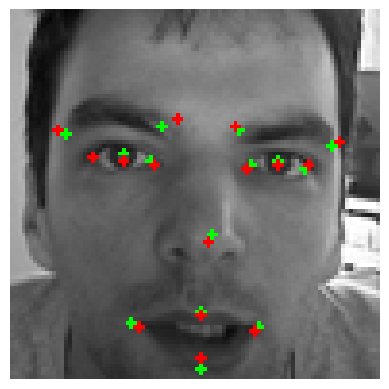

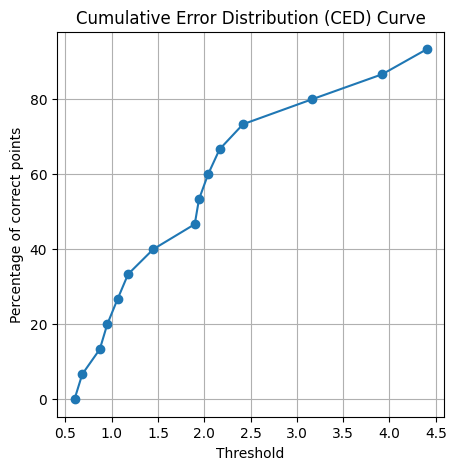

,true_x,detected_x,true_y,detected_y,diff_xy,euclidean_distance,mse,mae,r_squared,rmse,pck01,pck03,pck05,pck1
left_eye_center,69.680748,69.0,39.968748,40.0,"(0.6807476636000018, -0.03125233640000147)",0.681465,0.464394,0.712000,0,0.681465,0.0,0.0,0.0,100.0
right_eye_center,29.183551,29.0,37.563364,39.0,"(0.18355140190000085, -1.4366355140000024)",1.448314,2.097613,1.620187,0,1.448314,0.0,0.0,0.0,0.0
left_eye_inner_corner,62.864299,61.0,40.169271,41.0,"(1.8642990653999973, -0.8307289720000028)",2.041010,4.165722,2.695028,0,2.041010,0.0,0.0,0.0,0.0
left_eye_outer_corner,76.898243,77.0,41.171888,40.0,"(-0.10175700930000176, 1.1718878504999992)",1.176297,1.383676,1.273645,0,1.176297,0.0,0.0,0.0,0.0
right_eye_inner_corner,36.401047,37.0,39.367626,40.0,"(-0.5989532709999992, -0.6323738318000025)",0.871000,0.758642,1.231327,0,0.871000,0.0,0.0,0.0,100.0
right_eye_outer_corner,21.765533,21.0,38.565533,38.0,"(0.7655327103000005, 0.5655327102999976)",0.951771,0.905868,1.331065,0,0.951771,0.0,0.0,0.0,100.0
left_eyebrow_inner_end,59.766280,58.0,31.651290,30.0,"(1.7662803738000008, 1.6512897196000011)",2.417955,5.846504,3.417570,0,2.417955,0.0,0.0,0.0,0.0
left_eyebrow_outer_end,83.313645,85.0,35.358056,34.0,"(-1.686355140200007, 1.3580560747999968)",2.165204,4.688110,3.044411,0,2.165204,0.0,0.0,0.0,0.0
right_eyebrow_inner_end,39.408000,43.0,30.546393,28.0,"(-3.5919999999999987, 2.5463925234000016)",4.403019,19.386579,6.138393,0,4.403019,0.0,0.0,0.0,0.0
right_eyebrow_outer_end,14.949084,12.0,32.150131,31.0,"(2.9490841120999995, 1.150130841100001)",3.165422,10.019898,4.099215,0,3.165422,0.0,0.0,0.0,0.0


In [20]:
# ВЫБЕРИ ФОТО
pic = 5

sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
visualize_prediction(sample_image, prediction[pic])
area_under_ced(prediction[pic].euclidean_distance, print=True)

prediction[pic]

In [21]:
my_metric.iloc[1]

euclidean_distance     1.173605
mse                    1.779025
mae                    1.483971
r_squared              0.000000
rmse                   1.173605
pck01                  0.000000
pck03                  0.000000
pck05                 20.000000
pck1                  40.000000
auc                    1.540525
Name: 2, dtype: float64

In [22]:
def print_top(top):
    for pic, value in top:
        print(f"image {pic}: {value}")
        sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
        visualize_prediction(sample_image, prediction[pic])
        print(f"Area Under the CED Curve (AUC CED): {area_under_ced(prediction[pic].euclidean_distance)}")

### Выбор метрики

In [23]:
print(f"Доступные метрики: {my_metric.columns.to_list()}")

Доступные метрики: ['euclidean_distance', 'mse', 'mae', 'r_squared', 'rmse', 'pck01', 'pck03', 'pck05', 'pck1', 'auc']


In [24]:
metric = "auc"
num_top = 10

### Наихудшее качество детектирования

Как видно из изображений - наихудший результат детектирования не говорит о проблеме в модели, а показывает, что у нас могут быть неверные тестовые данные.

image 1995: 19.569652308763025


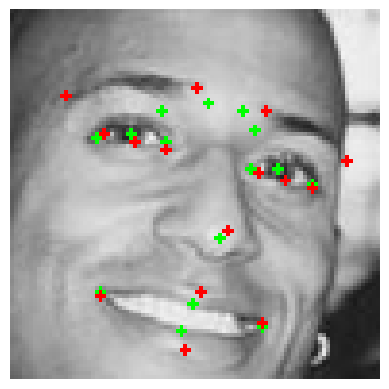

Area Under the CED Curve (AUC CED): 19.569652308763025
image 6788: 15.590680217666197


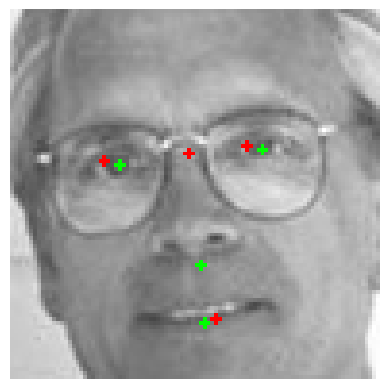

Area Under the CED Curve (AUC CED): 15.590680217666197
image 1996: 13.076712241087243


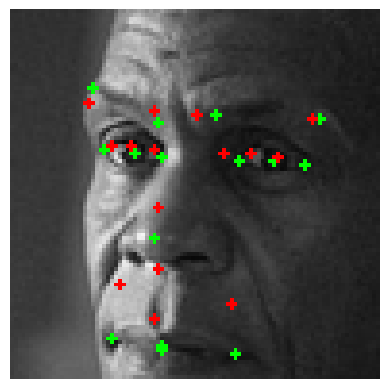

Area Under the CED Curve (AUC CED): 13.076712241087243
image 4860: 12.896808946593719


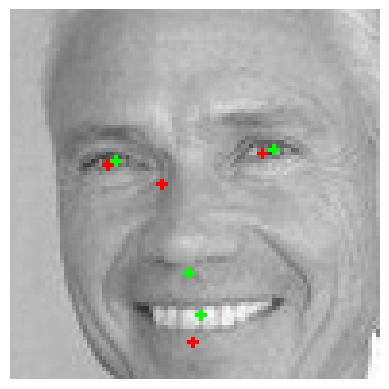

Area Under the CED Curve (AUC CED): 12.896808946593719
image 6815: 11.509373212861494


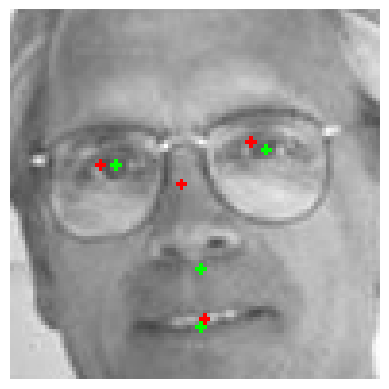

Area Under the CED Curve (AUC CED): 11.509373212861494
image 6754: 11.380011897366492


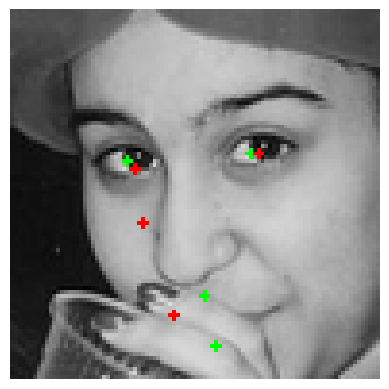

Area Under the CED Curve (AUC CED): 11.380011897366492
image 6873: 10.897646511348222


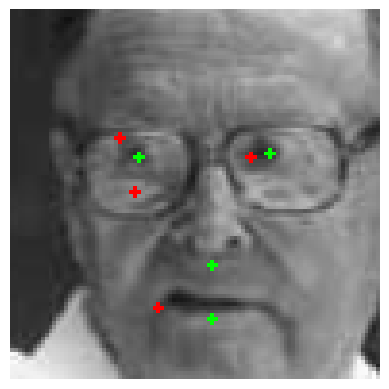

Area Under the CED Curve (AUC CED): 10.897646511348222
image 1907: 10.767491062605


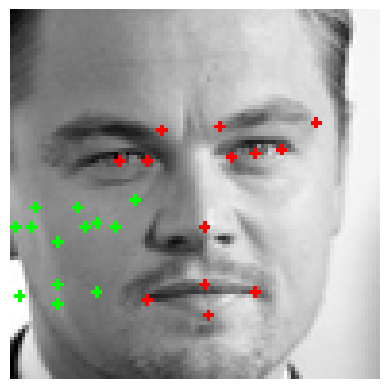

Area Under the CED Curve (AUC CED): 10.767491062605
image 6517: 10.66545581564294


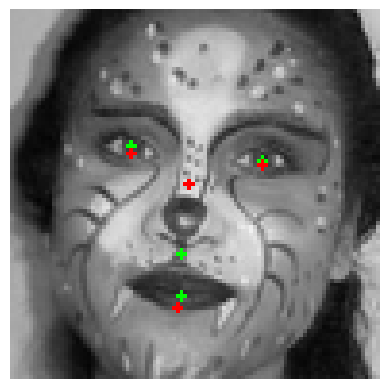

Area Under the CED Curve (AUC CED): 10.66545581564294
image 5122: 10.131172006673136


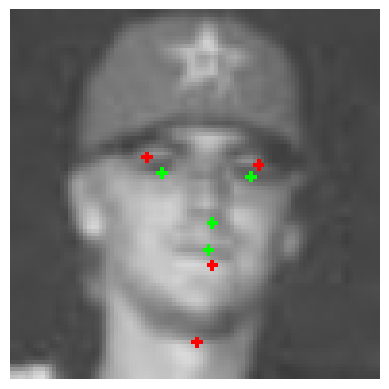

Area Under the CED Curve (AUC CED): 10.131172006673136


In [25]:
top_worst_detection = sorted(my_metric[metric].items(), key=lambda x: x[1], reverse=True)[:num_top]
print_top(top_worst_detection)

### Наилучшее качество детектирования

image 2694: 0.16357660033304883


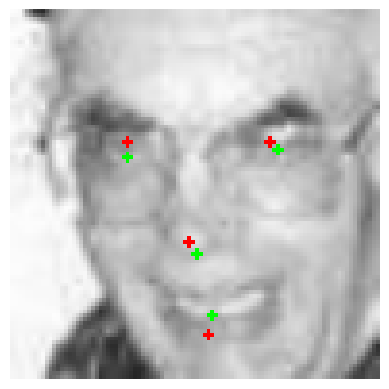

Area Under the CED Curve (AUC CED): 0.16357660033304883
image 5989: 0.3863188765672693


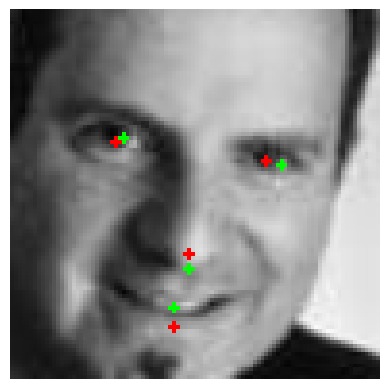

Area Under the CED Curve (AUC CED): 0.3863188765672693
image 5879: 0.4478981974703487


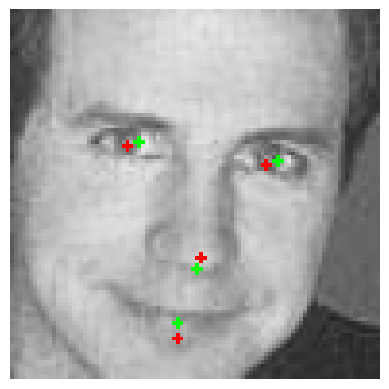

Area Under the CED Curve (AUC CED): 0.4478981974703487
image 4172: 0.5187250161077662


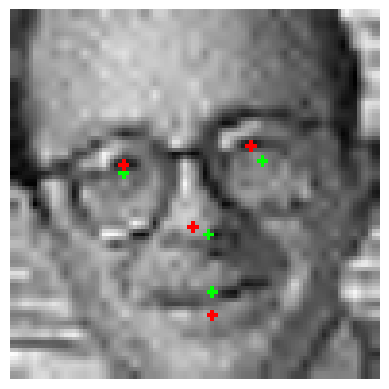

Area Under the CED Curve (AUC CED): 0.5187250161077662
image 1451: 0.5212447506041599


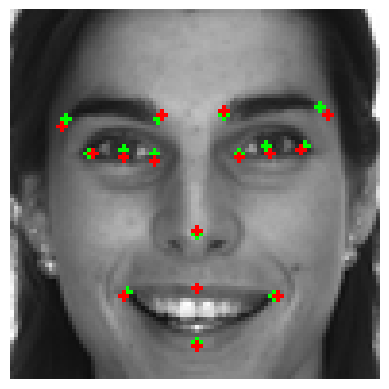

Area Under the CED Curve (AUC CED): 0.5212447506041599
image 5979: 0.5429574481754074


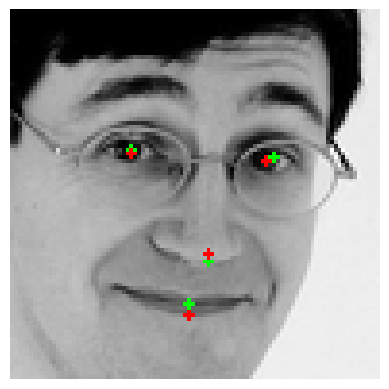

Area Under the CED Curve (AUC CED): 0.5429574481754074
image 5804: 0.5596060697220722


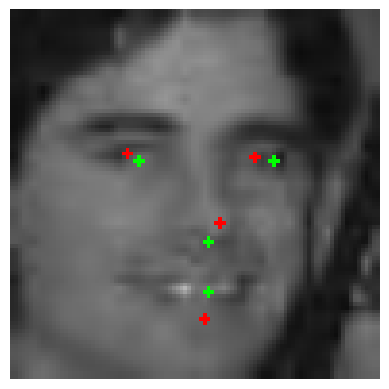

Area Under the CED Curve (AUC CED): 0.5596060697220722
image 205: 0.57348701565888


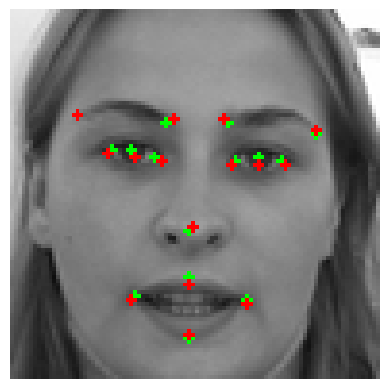

Area Under the CED Curve (AUC CED): 0.57348701565888
image 2598: 0.5779461161067456


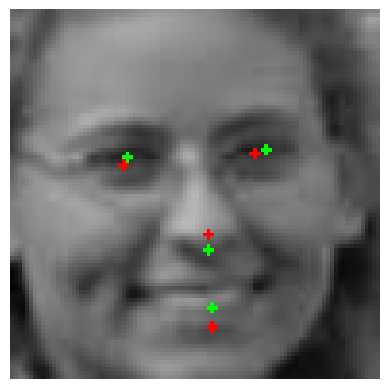

Area Under the CED Curve (AUC CED): 0.5779461161067456
image 545: 0.5905592657052179


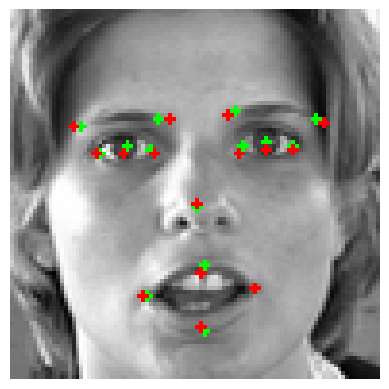

Area Under the CED Curve (AUC CED): 0.5905592657052179


In [26]:
top_best_detection = sorted(my_metric[metric].items(), key=lambda x: x[1], reverse=False)[:num_top]
print_top(top_best_detection)

# 3. Работа с инструментами разметки

Мы видим, что модель некоторые точки неверно детектирует на скачанных нами лицах и мы хотим отправить эти данные на разметку человеком. Для этого мы хотим в инструмент для разметки данных загрузить изображения и предсказания модели для последующего исправления людьми. Соответственно в этом задании нужно:

1. завести если нет аккаунт на сервисе supervisely

2. почитать документацию и разобраться с SDK/Python-API для supervisely

3. написать код для загрузки данных в supervisely (в этом же jupyter-notebook)

4. загрузить 5-10 изображений и предсказаний модели в supervisely и вставить скриншот с работающего сервиса

5. замерьте скорость разметки и оцените время разметки с нуля и время доразметки результатов работы модели


In [ ]:
# Токен находится в папке tokens с названием supervisely.txt
api_token = ""
address = ???
api = sly.Api(address, api_token)

# Создание проекта и датасета
workspace_name = 'your_workspace'
project_name = 'your_project'
project = api.project.create(workspace_name, project_name)
dataset_name = 'your_dataset'
dataset = api.dataset.create(project.id, dataset_name)

# Загрузка разметки из файла (например, COCO)
annotation_path = '/path/to/annotations.json'
sly.io.import_annotations_from_json(dataset.id, annotation_path)

# Закрытие проекта
api.project.close(project.id)